In [1]:
import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [46]:
# Matplotlib figure size to have large enough image plotting
#FIGURE_SIZE = (12, 6)
FIGURE_SIZE = (12, 18)

def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    """ A helper for plotting a grayscale image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

In [47]:
IMG_PATH = "/home/rattus/Free/Udacity/CarND-Capstone/imgs/traffic/samples"
images = os.listdir(IMG_PATH)
images.sort()

In [143]:
SAT_THR = 160
VAL_THR = 135

In [156]:
def clamp_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    blue = img[:,:,0]
    blue_mean = blue.mean()
    sat = hsv[:,:,2]
    val = hsv[:,:,1]
    mask = np.zeros(sat.shape)
    mask[sat > SAT_THR] += 50
    mask[val > VAL_THR] += 50
    mask[mask < 100] = 0
    mask[mask >= 100] = 1
    return mask.astype(np.uint8)

In [157]:
def detect_state(masked_light):
    red_mean = masked_light[:,:,2].mean()
    green_mean = masked_light[:,:,1].mean()
    blue_mean = masked_light[:,:,0].mean()
    
    red_green_diff_ratio = (red_mean + green_mean) / (abs(red_mean - green_mean)*2. + 0.01)
    non_blue_ratio = max(0., (red_mean + green_mean) - (2. * blue_mean))
    print("r-g, nonbl ", red_green_diff_ratio, non_blue_ratio)
    yellow_mean = red_green_diff_ratio * non_blue_ratio
    # States: 0 - red, 1 - yellow, 2 - green, 4 - Unknown
    print("R, G, B, Y : {:0.2f}, {:0.2f}, {:0.2f}, {:0.2f}"
          .format(red_mean, green_mean, blue_mean, yellow_mean))
    indices = np.array([red_mean, yellow_mean, green_mean])
    if (indices.max() < 0.15 or indices.max() < blue_mean):
        return 4
    return indices.argmax()

In [158]:
def draw_state(image, state):
    font = cv2.FONT_HERSHEY_SIMPLEX 
    states = ["Red", "Yellow", "Green", "Unknown", "Unknown"]
    state_str = states[state]

    org = (10, 35) 
    fontScale = 1.2
    color = (250, 250, 250) 
    thickness = 2

    result = cv2.putText(image, state_str, org, font,
                   fontScale, color, thickness, cv2.LINE_AA) 
    return result

r-g, nonbl  13.219313682358132 0.0
R, G, B, Y : 2.60, 2.41, 2.64, 0.00
r-g, nonbl  5.892466652088341 0.0
R, G, B, Y : 23.02, 27.28, 29.99, 0.00
r-g, nonbl  24.57159353348728 0.27945000000000003
R, G, B, Y : 0.18, 0.18, 0.04, 6.87
r-g, nonbl  0.6618475403680059 0.12724999999999997
R, G, B, Y : 0.15, 0.02, 0.02, 0.08
r-g, nonbl  7.309220422971424 0.0
R, G, B, Y : 2.57, 2.94, 2.91, 0.00
r-g, nonbl  0.0 0.0
R, G, B, Y : 0.00, 0.00, 0.00, 0.00
r-g, nonbl  5.029041503799405 0.0
R, G, B, Y : 35.19, 42.95, 53.29, 0.00
r-g, nonbl  4.3403490692790365 0.0
R, G, B, Y : 9.82, 12.37, 15.22, 0.00
r-g, nonbl  6.108059109256344 0.6043833333333333
R, G, B, Y : 1.61, 1.37, 1.19, 3.69
r-g, nonbl  2.133227597145123 0.05266666666666667
R, G, B, Y : 0.11, 0.07, 0.06, 0.11
r-g, nonbl  1.5596506936503483 0.0
R, G, B, Y : 3.28, 6.36, 4.95, 0.00
r-g, nonbl  25.118175778335715 0.0
R, G, B, Y : 75.35, 78.40, 82.56, 0.00
r-g, nonbl  5.051482900302389 0.0
R, G, B, Y : 33.84, 41.27, 51.24, 0.00
r-g, nonbl  1.03727543

True

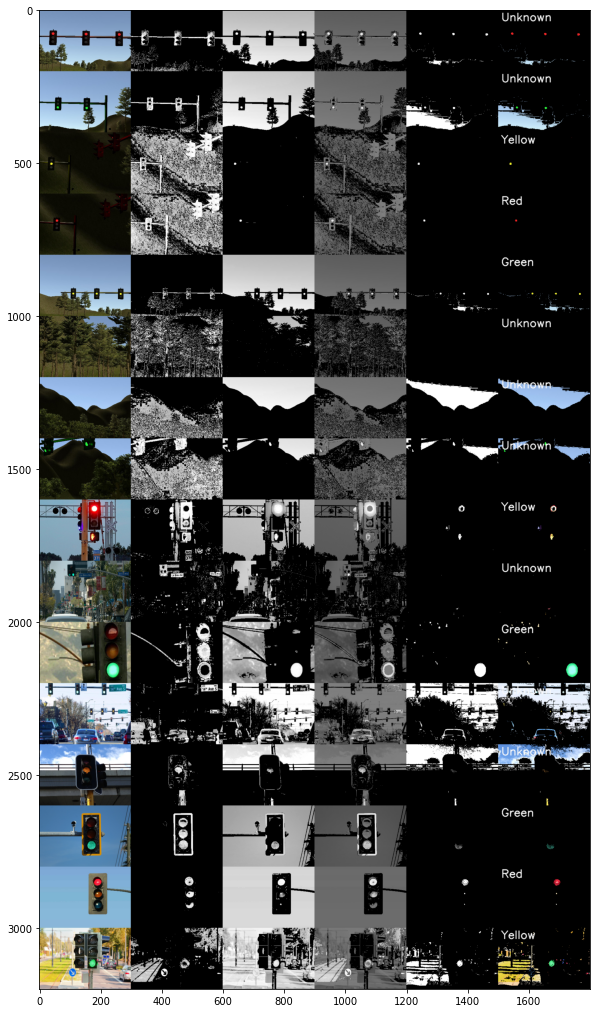

In [159]:
idx = 13
illustrations = []
for i in range(len(images)):
#for i in range(idx, idx+1):
    img = cv2.resize(cv2.imread(os.path.join(IMG_PATH, images[i])), (300,200))
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    sat = hsv[:,:,1]
    val = hsv[:,:,2]
    sat[sat < SAT_THR] = 0
    val[val < VAL_THR] = 0
    mask = clamp_saturation(img)
    gray_parts = np.expand_dims(np.concatenate((sat, val, (sat//2)+(val//2), mask*255), axis=1),2)
    gray_parts_as_bgr = np.concatenate((gray_parts,gray_parts,gray_parts), axis=2)
    
    lights_only = np.zeros(img.shape)
    lights_only = cv2.bitwise_and(img, img, mask=mask)
    state = detect_state(lights_only)
    
    all_stripe = np.concatenate(
        (img, gray_parts_as_bgr, draw_state(lights_only, state)),
        axis=1)
    illustrations.append(all_stripe)

illustrations = np.concatenate(np.array(illustrations), axis = 0)
plot_bgr(illustrations)
cv2.imwrite("illustrations.jpg", illustrations)